In [7]:
import random
import pandas as pd
import numpy as np
from numpy import atleast_2d
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.decomposition import TruncatedSVD 
from sklearn import random_projection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import cross_val_score
import seaborn as sns; sns.set()  # for plot styling
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.spatial.distance import cdist
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

Load the Drug Study data

In [3]:
my_data = pd.read_csv("drug200.csv", delimiter=",")
my_data[0:5]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


## Prepocessing Data Set

Column datatypes

In [4]:
print (my_data.dtypes)
print (my_data.shape)

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object
(200, 6)


We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [5]:
X = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]

array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.113999999999999],
       [28, 'F', 'NORMAL', 'HIGH', 7.797999999999999],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

In [8]:
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]

array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.113999999999999],
       [28, 0, 2, 0, 7.797999999999999],
       [61, 0, 1, 0, 18.043]], dtype=object)

In [9]:
X.shape

(200, 5)

Preprocess Y variable

In [10]:
y = my_data["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

In [11]:
le_Drug = preprocessing.LabelEncoder()
le_Drug.fit(['drugA', 'drugB', 'drugC','drugX', 'drugY'])
y = le_Drug.transform(my_data['Drug'])
y[:20]

array([4, 2, 2, 3, 4, 3, 4, 2, 4, 4, 2, 4, 4, 4, 3, 4, 3, 0, 2, 4])

In [12]:
my_data['Drug'] = y
my_data.head(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,4
1,47,M,LOW,HIGH,13.093,2
2,47,M,LOW,HIGH,10.114,2
3,28,F,NORMAL,HIGH,7.798,3
4,61,F,LOW,HIGH,18.043,4


In [13]:
data = pd.DataFrame(X, columns = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], index = None)
data.head(5)

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,0,0,25.355
1,47,1,1,0,13.093
2,47,1,1,0,10.114
3,28,0,2,0,7.798
4,61,0,1,0,18.043


In [26]:
data['Class'] = y
data.head(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Clus_km,Class
0,23,0,0,0,25.355,0,4
1,47,1,1,0,13.093,1,2
2,47,1,1,0,10.114,1,2
3,28,0,2,0,7.798,0,3
4,61,0,1,0,18.043,0,4


In [23]:
print (data.dtypes)
print (data.shape)

Age            object
Sex            object
BP             object
Cholesterol    object
Na_to_K        object
Clus_km         int32
dtype: object
(200, 6)


In [24]:
#cancer = cancer[pd.to_numeric(cancer['BareNuc'],errors ='coerrce').notnull()]
data['Age'] = data['Age'].astype('int')
data['Sex'] = data['Sex'].astype('int')
data['BP'] = data['BP'].astype('int')
data['Cholesterol'] = data['Cholesterol'].astype('int')
data['Na_to_K'] = data['Na_to_K'].astype('float')

print (data.dtypes)
print (data.shape)

Age              int64
Sex              int64
BP               int64
Cholesterol      int64
Na_to_K        float64
Clus_km          int32
dtype: object
(200, 6)


#### Normalizing over the standard deviation
Normalize the dataset using __StandardScaler()__ 

In [15]:
feature_df = data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']]
X = np.asarray(feature_df)
M = StandardScaler().fit_transform(X)
M[0:5]

array([[-1.29159102, -1.040833  , -1.11016894, -0.97043679,  1.28652212],
       [ 0.16269866,  0.96076892,  0.10979693, -0.97043679, -0.4151454 ],
       [ 0.16269866,  0.96076892,  0.10979693, -0.97043679, -0.82855818],
       [-0.988614  , -1.040833  ,  1.32976279, -0.97043679, -1.14996267],
       [ 1.0110343 , -1.040833  ,  0.10979693, -0.97043679,  0.27179427]])

## kMeans Modeling

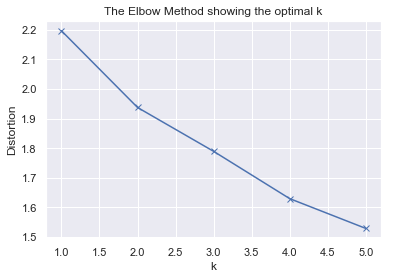

In [16]:
# k means determine k
distortions = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(M)
    kmeanModel.fit(M)
    distortions.append(sum(np.min(cdist(M, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / M.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [52]:
clusterNum = 2
k_means = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_means.fit(M)
labels = k_means.labels_
print(labels[0:5])

[0 0 0 0 0]


In [53]:
print (labels[0:25])

[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0]


In [54]:
cluster_centers = k_means.cluster_centers_
inertia = k_means.inertia_
n_iter = k_means.n_iter_

print (cluster_centers)
print (inertia)
print (n_iter)

[[ 0.06621666  0.00855053  0.13348559 -0.97043679 -0.00970481]
 [-0.07031253 -0.00907943 -0.14174243  1.03046381  0.0103051 ]]
795.2491851055647
4


## Insights
Assign labels to each row in dataframe

In [55]:
data["Clus_km"] = labels
data.head(20)

,Age,Sex,BP,Cholesterol,Na_to_K,Clus_km,Class
0,23,0,0,0,25.355,0,4
1,47,1,1,0,13.093,0,2
2,47,1,1,0,10.114,0,2
3,28,0,2,0,7.798,0,3
4,61,0,1,0,18.043,0,4
5,22,0,2,0,8.607,0,3
6,49,0,2,0,16.275,0,4
7,41,1,1,0,11.037,0,2
8,60,1,2,0,15.171,0,4
9,43,1,1,1,19.368,1,4


We can easily check the centroid values by averaging the features in each cluster.

In [50]:
#cancer.drop(columns = ['Class'], inplace = True)
data.groupby('Clus_km').mean()

,Age,Sex,BP,Cholesterol,Na_to_K,Class
Clus_km,,,,,,
0,45.932692,1.0,0.903846,0.480769,15.219029,2.740385
1,42.562500,0.0,0.916667,0.489583,17.022062,3.010417


Text(0.5, 1.0, 'K-Means Cluster Centers')

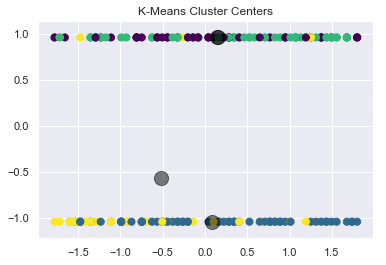

In [45]:
y_kmeans = k_means.predict(M)
plt.scatter(M[:, 0], M[:, 1], c=y_kmeans, s=50, cmap = 'viridis')

centers = k_means.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('K-Means Cluster Centers')

Look at distribution based on Clump and BareNuc

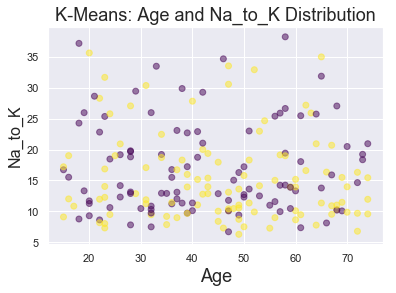

In [35]:
#area = np.pi * ( X[:, 1])**2  
plt.scatter(X[:, 0], X[:, 4], c=labels.astype(np.float), alpha=0.5, cmap = 'viridis')
plt.xlabel('Age', fontsize=18)
plt.ylabel('Na_to_K', fontsize=16)
plt.title('K-Means: Age and Na_to_K Distribution', fontsize=18)
plt.show()

In [ ]:
area = np.pi * ( M[:, 1])**2  
plt.scatter(M[:, 1], M[:, 5], s=area, c=labels.astype(np.float), alpha=1.0)
plt.xlabel('UnifSize', fontsize=18)
plt.ylabel('BareNuc', fontsize=16)
plt.title('K-Means: UnifSize and BareNuc Distribution')
plt.show()

Text(0.0, 1.0, '3-D K-Means')

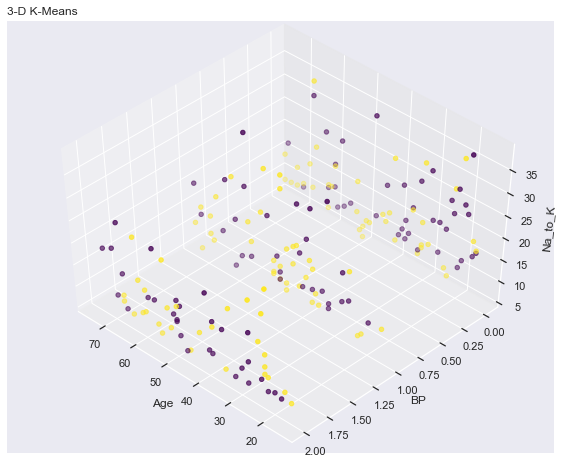

In [36]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Age')
ax.set_ylabel('BP')
ax.set_zlabel('Na_to_K')

ax.scatter(X[:, 0], X[:, 2], X[:, 4], c= labels.astype(np.float), cmap = 'viridis')
plt.title("3-D K-Means", loc = "left")
#plt.legend()

k-means partitions data patients into mutually exclusive groups, for example, into 2 clusters. The patients in each cluster are similar to each other inifSize, BareNuc, and Clump thickness.
Now we can create a profile for each group, considering the common characteristics of each cluster. 
For example, the 2 clusters can be:

- Clump thickness < 6, InifSize < 4
- BareNuc > 4 and Clump > 4


## Expectation Maximization

In [79]:
np.random.seed(1)
gmm = GaussianMixture(n_components = 2)
gmm.fit(M)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [85]:
label_gmm = gmm.predict(M)

In [86]:
data['Clus_gmm'] = gmm.predict(M)
data.head(10)

,Age,Sex,BP,Cholesterol,Na_to_K,Clus_km,Class,Clus_gmm
0,23,0,0,0,25.36,0,4,1
1,47,1,1,0,13.09,0,2,0
2,47,1,1,0,10.11,0,2,0
3,28,0,2,0,7.80,0,3,1
4,61,0,1,0,18.04,0,4,1
5,22,0,2,0,8.61,0,3,1
6,49,0,2,0,16.27,0,4,1
7,41,1,1,0,11.04,0,2,0
8,60,1,2,0,15.17,0,4,0
9,43,1,1,1,19.37,1,4,0


In [87]:
#cancer['Label'] = y
#cancer.head(10)
data.groupby('Clus_gmm').mean()

,Age,Sex,BP,Cholesterol,Na_to_K,Clus_km,Class
Clus_gmm,,,,,,,
0,45.93,1.00,0.90,0.48,15.22,0.48,2.74
1,42.56,0.00,0.92,0.49,17.02,0.49,3.01


### Visualize GMM cluster

In [88]:
cmap = cm.get_cmap('viridis')
pd.options.display.float_format = '{:,.2f}'.format

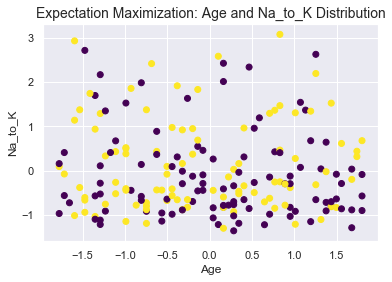

In [90]:
#area = np.pi * ( M[:, 1])**2  
plt.scatter(M[:, 0], M[:, 4], c=label_gmm.astype(np.float), alpha=1.0, cmap = 'viridis')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Na_to_K', fontsize=12)
plt.title('Expectation Maximization: Age and Na_to_K Distribution', fontsize = 14)
plt.show()

In [ ]:
area = np.pi * ( M[:, 1])**2  
plt.scatter(M[:, 1], M[:, 5], s=area, c=label_gmm.astype(np.float), alpha=0.5)
plt.xlabel('UnifSize', fontsize=18)
plt.ylabel('BareNuc', fontsize=16)

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Clump')
ax.set_ylabel('UnifSize')
ax.set_zlabel('BareNuc')
#CS = ax.contourf3D(X[:,0], X[:,1], X[:,5], cmap='RdBu_r', alpha=.5)
#CB = plt.colorbar(CS, shrink=0.8)

ax.scatter(M[:, 0], M[:, 1], M[:, 5], c= label_gmm.astype(np.float))
plt.title("3-D Expectation Maximization", loc = "left")

In [91]:
gmm.weights_

array([0.52, 0.48])

In [92]:
xmin, ymin = features_2D.min(axis=0)
xmax, ymax = features_2D.max(axis=0)

x = np.linspace(xmin, xmax, 500)
y = np.linspace(ymin, ymax, 500)
X, Y = np.meshgrid(x, y)

simulated_2D = np.column_stack([np.ravel(X), np.ravel(Y)])
simulated_4D = pca.inverse_transform(simulated_2D)
Z = atleast_2d(np.clip(np.exp(gmm.score_samples(simulated_4D)), a_min=0, a_max=1)).reshape(X.shape)

simulated_2D = np.column_stack([np.ravel(X), np.ravel(Y)])
simulated_4D = pca.inverse_transform(simulated_2D)
Z = atleast_2d(np.clip(np.exp(gmm.score_samples(simulated_4D)), a_min=0, a_max=1)).reshape(X.shape)

Text(0.5, 1.0, 'GMM Cluster Probabilities with PCA')

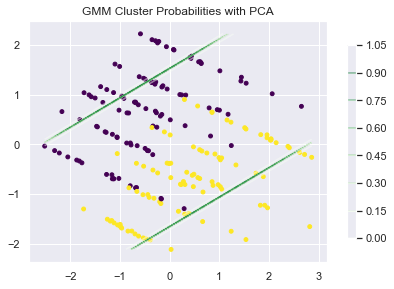

In [93]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
CS = ax.contour(X, Y, Z, cmap='Greens', alpha=.5)
CB = plt.colorbar(CS, shrink=0.8)
ax.scatter(*features_2D.T, c=label_gmm.astype(np.float), s=15, cmap = 'viridis')
fig.tight_layout();
plt.title("GMM Cluster Probabilities with PCA")

## Dimensionality Reduction

### PCA

In [74]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(M)

In [75]:
features_2D

array([[ 1.82664043, -1.22613604],
       [-1.06244655,  0.14952922],
       [-1.28039643,  0.24202363],
       [-0.84068738, -1.74707243],
       [-0.31682758, -1.08517411],
       [-0.62649705, -1.84773399],
       [-0.763     , -1.74587244],
       [-1.05786562,  0.1378225 ],
       [-1.87308005, -0.31582002],
       [ 0.24253496,  0.99680318],
       [-0.41432108, -1.06657894],
       [ 1.83463849,  0.19596341],
       [-0.7920827 ,  0.02828273],
       [-0.44056876, -1.01150795],
       [-1.05016869, -1.62237557],
       [ 2.03018909,  0.08368695],
       [-1.00807285,  1.56984577],
       [-0.26797605,  0.63638173],
       [-0.8664121 ,  0.02728477],
       [ 2.38197906, -0.03957332],
       [-0.13669573,  1.18052208],
       [-1.1643813 , -0.61169902],
       [ 0.95861559,  0.69941854],
       [-0.2009879 , -1.155487  ],
       [ 1.53635818, -1.91719528],
       [ 1.96110747,  0.13252937],
       [ 1.24144767, -0.02371865],
       [-0.52482487, -0.43935461],
       [ 1.33456476,

In [ ]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure().gca(title='2D Projection for True Values Dimensionality Reduction', 
                      xlabel='Explained Variance: {:.2%}'.format(ev1), 
                      ylabel='Explained Variance: {:.2%}'.format(ev2))
ax.scatter(*features_2D.T, c= y.astype(np.float), s=10);

In [ ]:
plt.plot(range(4), pca.explained_variance_ratio_)
plt.plot(range(4), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")
plt.show()

In the above graph, the blue line represents component-wise explained variance while the orange line represents the cumulative explained variance. We are able to explain around 70% variance in the dataset using just two components. Let us now try to visualize each of these decomposed components:

The singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space.

In [ ]:
pca.singular_values_

### ICA

In [ ]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(M)

# For comparison, compute PCA
pca = PCA(n_components=2)
H = pca.fit_transform(M)  # Reconstruct signals based on orthogonal components

In [ ]:
plt.figure(figsize=(8,5))
plt.title('ICA Components')
plt.scatter(S_[:,0], S_[:,1])
plt.scatter(S_[:,1], S_[:,2])
plt.scatter(S_[:,2], S_[:,0])

The data has been separated into different independent components which can be seen very clearly in the above image. X-axis and Y-axis represent the value of decomposed independent components.

### Singular Value Decomposition

We can also use Singular Value Decomposition (SVD) to decompose our original dataset into its constituents, resulting in dimensionality reduction. To learn the mathematics behind SVD, refer to this article.

SVD decomposes the original variables into three constituent matrices. It is essentially used to remove redundant features from the dataset. It uses the concept of Eigenvalues and Eigenvectors to determine those three matrices. We will not go into the mathematics of it due to the scope of this article, but let’s stick to our plan, i.e. reducing the dimensions in our dataset.

Let’s implement SVD and decompose our original variables:

In [ ]:
svd = TruncatedSVD(n_components=3, random_state=42).fit_transform(M)

In [ ]:
plt.figure(figsize=(12,8))
plt.title('SVD Components')
plt.scatter(svd[:,0], svd[:,1])
plt.scatter(svd[:,1], svd[:,2])
plt.scatter(svd[:,2],svd[:,0])

### Random Projection

In [ ]:
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5, n_components=3, n_jobs=-1).fit_transform(M)

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using Random Projection')
plt.scatter(trans_data[:,0], trans_data[:,1])
plt.scatter(trans_data[:,1], trans_data[:,2])
plt.scatter(trans_data[:,2], trans_data[:,0])

## Apply Clustering Algorithms to Dimensionality Reduction Data

### K-means Clustering with Dimensionality (PCA, ICA, Random, SVD)

In [ ]:
pca = PCA(n_components=4)
A = pca.fit_transform(M)

In [ ]:
A

In [ ]:
clusterNum = 2
k_means = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_means.fit(A)
label_A = k_means.labels_
print(label_A[0:5])


In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(A[:, 0], A[:, 1], A[:, 2], c= label_A.astype(np.float))
plt.title("3-D K-Means with PCA Dimensionality Reduction", loc = "left")
#plt.legend()

In [ ]:
ica = FastICA(n_components=4)
B = ica.fit_transform(M)


In [ ]:
clusterNum = 2
k_meanB = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_meanB.fit(B)
label_B = k_meanB.labels_
print(label_B[0:5])

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(B[:, 0], B[:, 1], B[:, 2], c= label_B.astype(np.float))
plt.title("3-D K-Means with ICA Dimensionality Reduction", loc = "left")
#plt.legend()

In [ ]:
clusterNum = 2
k_meanC = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_meanC.fit(svd)
label_C = k_meanC.labels_
print(label_C[0:5])

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(svd[:, 0], svd[:, 1], svd[:, 2], c= label_C.astype(np.float))
plt.title("3-D K-Means with SVD Dimensionality Reduction", loc = "left")
#plt.legend()

In [ ]:
clusterNum = 2
k_meanD = KMeans(init = "random", n_clusters = clusterNum, n_init = 10)
k_meanD.fit(trans_data)
label_D = k_meanD.labels_
print(label_D[0:5])

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(trans_data[:, 0], trans_data[:, 1], trans_data[:, 2], c= label_C.astype(np.float))
plt.title("3-D K-Means with Random Projection Dimensionality Reduction", loc = "left")
#plt.legend()

### Expectation Maximization with Dimesionality (PCA, ICA, Random Project, SVD)

In [ ]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(A)
labelA_gmm = gmm.predict(A)

In [ ]:
labelA_gmm[0:5]

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(A[:, 0], A[:, 1], A[:, 2], c= labelA_gmm.astype(np.float))
plt.title("3-D Expectation Maximization with PCA Dimensionality Reduction", loc = "left")
#plt.legend()

In [ ]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(B)
labelB_gmm = gmm.predict(B)

In [ ]:
labelB_gmm[0:5]

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(B[:, 0], B[:, 1], B[:, 2], c= labelB_gmm.astype(np.float))
plt.title("3-D Expectation Maximization with ICA Dimensionality Reduction", loc = "left")
#plt.legend()

In [ ]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(svd)
labelsvd_gmm = gmm.predict(svd)

In [ ]:
labelsvd_gmm[0:5]

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(svd[:, 0], svd[:, 1], svd[:, 2], c= labelsvd_gmm.astype(np.float))
plt.title("3-D Expectation Maximization with SVD Dimensionality Reduction", loc = "left")
#plt.legend()

In [ ]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(trans_data)
labelD_gmm = gmm.predict(trans_data)

In [ ]:
labelD_gmm[0:5]

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.scatter(trans_data[:, 0], trans_data[:, 1], trans_data[:, 2], c= labelD_gmm.astype(np.float))
plt.title("3-D Expectation Maximization with Random Projection Dimensionality Reduction", loc = "left")
#plt.legend()

### Apply Neural Networks to Dimesionality Reduction Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.3, random_state=3)

mlp = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print(classification_report(y_test,predictions))
print("Neural Network (PCA) Accuracy: ", metrics.accuracy_score(y_test, predictions))

In [ ]:
B_train, B_test, b_train, b_test = train_test_split(B, y, test_size=0.3, random_state=3)

mlpB = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlpB.fit(B_train,b_train)
predictionsB = mlpB.predict(B_test)
print(classification_report(b_test,predictionsB))
print("Neural Network (ICA) Accuracy: ", metrics.accuracy_score(b_test, predictionsB))

In [ ]:
S_train, S_test, s_train, s_test = train_test_split(svd, y, test_size=0.3, random_state=3)

mlpS = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlpS.fit(S_train,s_train)
predictionsS = mlpS.predict(S_test)
print(classification_report(s_test,predictionsS))
print("Neural Network (SVD) Accuracy: ", metrics.accuracy_score(s_test, predictionsS))

In [ ]:
T_train, T_test, t_train, t_test = train_test_split(trans_data, y, test_size=0.3, random_state=3)

mlpT = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlpT.fit(T_train,t_train)
predictionsT = mlpT.predict(T_test)
print(classification_report(t_test,predictionsT))
print("Neural Network (Random Projection) Accuracy: ", metrics.accuracy_score(t_test, predictionsT))

### Using Clustering Data for Neural Networks

In [ ]:
cancer.head(5)

In [ ]:
cancer.drop(columns = ['Class'], inplace = True)

In [ ]:
cancer.head(5)

Use label features "Class_km" and "Clus_gmm" for dataset and standardized dataset

In [ ]:
feature_nn = cancer[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit','Clus_km', 'Clus_gmm']]
J = np.asarray(feature_nn)
K = StandardScaler().fit_transform(J)
K[0:5]

In [ ]:
K_train, K_test, k_train, k_test = train_test_split(K, y, test_size=0.3, random_state=3)

mlpK = MLPClassifier(hidden_layer_sizes=(9,9),max_iter=500, solver='lbfgs')
mlpK.fit(K_train,k_train)
predictionsK = mlpK.predict(K_test)
print(classification_report(k_test,predictionsK))
print("Neural Network (SVD) Accuracy: ", metrics.accuracy_score(k_test, predictionsK))